In [2]:
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 4.5 MB 22.8 MB/s eta 0:00:01


In [19]:
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt


from utils.cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.cs231n.rnn_layers import *
#from utils.cs231n.captioning_solver import CaptioningSolver
#from utils.cs231n.classifiers.rnn import CaptioningRNN
from utils.cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from utils.cs231n.image_utils import image_from_url

from torch.utils.data import Dataset, DataLoader
from torch import nn

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


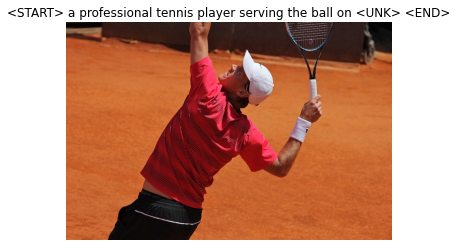

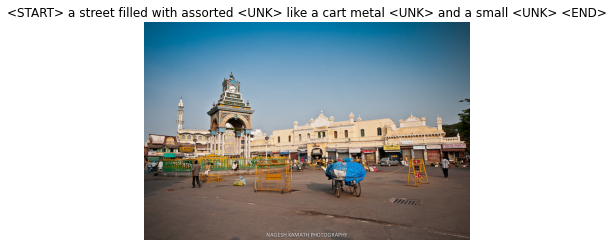

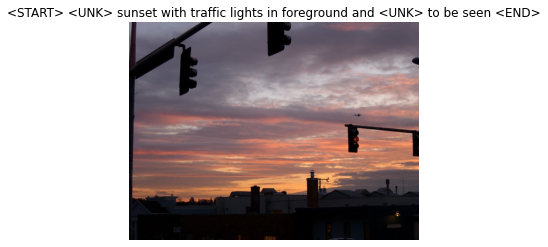

In [9]:
# Sample a minibatch and show the images and captions
batch_size = 3

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

In [39]:
# data['train_features'].shape
# data['train_captions'].shape
# len(data['word_to_idx'])
# data['idx_to_word']
# data['train_captions'][0]
dict_idx_to_word = {k:v for k,v in enumerate(data['idx_to_word'])}
# dict_idx_to_word
#for ind in data['train_captions'][0]
# np.apply_along_axis(lambda x: dict_idx_to_word[x], axis=0, arr=data['train_captions'][0])
'''
caption = ''
for i in data['train_captions'][2]:
    caption = caption + dict_idx_to_word[i] +' '
    
caption
''

'<START> a blue and white bathroom with <UNK> <UNK> wall <UNK> <END> <NULL> <NULL> <NULL> <NULL> <NULL> '

In [43]:
show_img_ind = 234
print(data['train_urls'][show_img_ind])
lst_captions = []
for arr_ind,img_ind in enumerate(data['train_image_idxs']):
    if img_ind == show_img_ind:
        lst_captions.append(arr_ind)

for cap_ind in lst_captions:
    caption = ''
    for i in data['train_captions'][cap_ind]:
        caption = caption + dict_idx_to_word[i] +' '
    print(caption)

http://farm6.staticflickr.com/5179/5568030633_63e3fb5e7a_z.jpg
<START> <UNK> moving train with <UNK> <UNK> off of it <END> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> 
<START> a blurry image of a train on a train track <END> <NULL> <NULL> <NULL> <NULL> <NULL> 
<START> a big long blue train that is on a rail road tracks <END> <NULL> <NULL> <NULL> 
<START> a train passing with sun <UNK> from its windows <END> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> 
<START> the sun <UNK> <UNK> off of the passenger train car windows <END> <NULL> <NULL> <NULL> <NULL> 


### RNN Strategy 

0. How do I handle input to the model? Read image and all 5 captions or just the top 1? Output at each time step is the 
    softmax proba of the input word.

1. Word vectors: Random initialization?

2. Combining Image features with the word vectors at each time step.

3. Creating y_t at each time step through softmax function

4. Masking the input tokens at each time step.

In [8]:
np.unique(data['train_image_idxs'])

array([    0,     1,     2, ..., 82780, 82781, 82782], dtype=int32)

In [ ]:
class ImageCaptioningDataset(Dataset):
    def __init__(self,is_train=True):
        
        '''
        train_captions <class 'numpy.ndarray'> (400135, 17) int32
        train_image_idxs <class 'numpy.ndarray'> (400135,) int32
        # val_captions <class 'numpy.ndarray'> (195954, 17) int32
        # val_image_idxs <class 'numpy.ndarray'> (195954,) int32
        train_features <class 'numpy.ndarray'> (82783, 512) float32
        # val_features <class 'numpy.ndarray'> (40504, 512) float32
        idx_to_word <class 'list'> 1004
        word_to_idx <class 'dict'> 1004
        train_urls <class 'numpy.ndarray'> (82783,) <U63
        # val_urls <class 'numpy.ndarray'> (40504,) <U63
        '''
        
        self.dict_data = load_coco_data(pca_features=True)
        self.is_train = is_train
        '''
        self.dict_image_to_loc = {}
        if self.is_train:
            self.map_image_to_loc()
            self.dict_image_captions = dict(k:[] for k in self.arr_image_ind)
        '''
    '''    
    def map_image_to_loc(self):
        if self.is_train:
            for loc_ind, img_ind in enumerate(self.dict_data['train_image_idxs']):
                try:
                    self.dict_image_to_loc[img_ind].append(loc_ind)
                except KeyError:
                    self.dict_image_to_loc[img_ind] = [loc_ind]
        else:
        `   for loc_ind, img_ind in enumerate(self.dict_data['val_image_idxs']):
                try:
                    self.dict_image_to_loc[img_ind].append(loc_ind)
                except KeyError:
                    self.dict_image_to_loc[img_ind] = [loc_ind]
    '''  
        
    def __len__(self):
        if self.is_train:
            return len(self.dict_data['train_image_idxs'])
        else:
            return len(self.dict_data['val_image_idxs'])
        
    def __getitem__(self,loc_idx):
        if self.is_train:
            image_ind = self.dict_data['train_image_idxs'][loc_idx]
            self.arr_image_features = self.dict_data['train_features'][image_ind]
            self.arr_caption_words = self.dict_data['train_captions'][loc_idx]
        else:
            image_ind = self.dict_data['val_image_idxs'][loc_idx]
            self.arr_image_features = self.dict_data['val_features'][image_ind]
            self.arr_caption_words = self.dict_data['val_captions'][loc_idx]
        
        # 0 = <NULL>
        self.mask = (self.arr_caption_words==0).astype(np.uint8)
        return self.arr_image_features, self.arr_caption_words, self.mask
        
        

In [16]:
class ImageCaptioningRNN(nn.Module):
    def __init__(self, image_size, vocab_size, hidden_size, embedding_size):
        super(ImageCaptioningRNN, self).__init__()
        self.vocab_size = vocab_size
        self.image_size = image_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        
        self.word_embeddings = nn.Embedding(num_embeddings=self.vocab_size, 
                                            embedding_dim=self.embedding_size, 
                                            padding_idx=0)
        

3

array([0, 0, 1, 0, 1, 0, 0, 0, 1], dtype=uint8)